<a href="https://colab.research.google.com/github/henthornlab/ProcessAnalytics/blob/master/ReverseOsmosisPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Principal Component Analysis**#
David B. Henthorn, Dept. of Chemical Engineering,
Rose-Hulman Institute of Technology

<img style="float: right;" src="https://raw.githubusercontent.com/henthornlab/ProcessAnalytics/master/RHITlogo.png">

Python example of using PCA on data commonly seen in the field of chemical engineering.

In [0]:
import pandas as pd

I went ahead and labeled some reverse osmosis data according to the experimental conditions. Load that as a dataframe.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/henthornlab/ProcessAnalytics/master/ROSampleRunsLabeled.csv", header = 0) 
# Now let's take a look at the imported data
df.head()

,Pressure (psig),Feed Conc. (ppm),Permeate Conc. (ppm),Concentrate Conc. (ppm),Feed Flow (l/min),Concentrate Flow (l/min),Permeate Flow (l/min),Recycle Flow (l/min),Label
0,49.822609,318.142090,2.857253,353.512390,6.677412,5.959144,0.678688,-0.000658,Low
1,49.822609,317.903900,2.857253,352.440613,6.641521,5.959144,0.681964,-0.000658,Low
2,49.827381,318.142090,2.857253,352.916992,6.665091,5.959144,0.679234,-0.000658,Low
3,49.846458,317.427612,2.857253,352.202393,6.619621,5.959144,0.669492,-0.000658,Low
4,49.870300,318.142090,2.857253,352.559692,6.561592,5.959144,0.671403,-0.000658,Low


The imported data has ungainly names to the columns, so let's rename them.

In [3]:
df.rename(columns={'Pressure (psig)': 'Pressure', 'Feed Conc. (ppm)': 'FeedConc', 'Permeate Conc. (ppm)': 'PermConc', 'Concentrate Conc. (ppm)': 'RetentateConc'}, inplace=True)
df.rename(columns={'Feed Flow (l/min)': 'FeedFlow', 'Concentrate Flow (l/min)': 'RetentateFlow', 'Permeate Flow (l/min)': 'PermFlow', 'Recycle Flow (l/min)': 'RecFlow'}, inplace=True)
#Reorder the columns
df = df[['Pressure', 'FeedFlow', 'RetentateFlow', 'PermFlow', 'FeedConc', 'RetentateConc', 'PermConc', 'RecFlow','Label' ]]
df.head()

,Pressure,FeedFlow,RetentateFlow,PermFlow,FeedConc,RetentateConc,PermConc,RecFlow,Label
0,49.822609,6.677412,5.959144,0.678688,318.142090,353.512390,2.857253,-0.000658,Low
1,49.822609,6.641521,5.959144,0.681964,317.903900,352.440613,2.857253,-0.000658,Low
2,49.827381,6.665091,5.959144,0.679234,318.142090,352.916992,2.857253,-0.000658,Low
3,49.846458,6.619621,5.959144,0.669492,317.427612,352.202393,2.857253,-0.000658,Low
4,49.870300,6.561592,5.959144,0.671403,318.142090,352.559692,2.857253,-0.000658,Low


The recycle on the reverse osmosis machine was closed, preventing flow. As such, all flow rates there are the same. This caused issues with the PCA algorithm and so we need to delete it.

In [0]:
df = df.drop(columns='RecFlow')

Let's take a look at the data. We'll use pair plots to look for correlations in the data.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


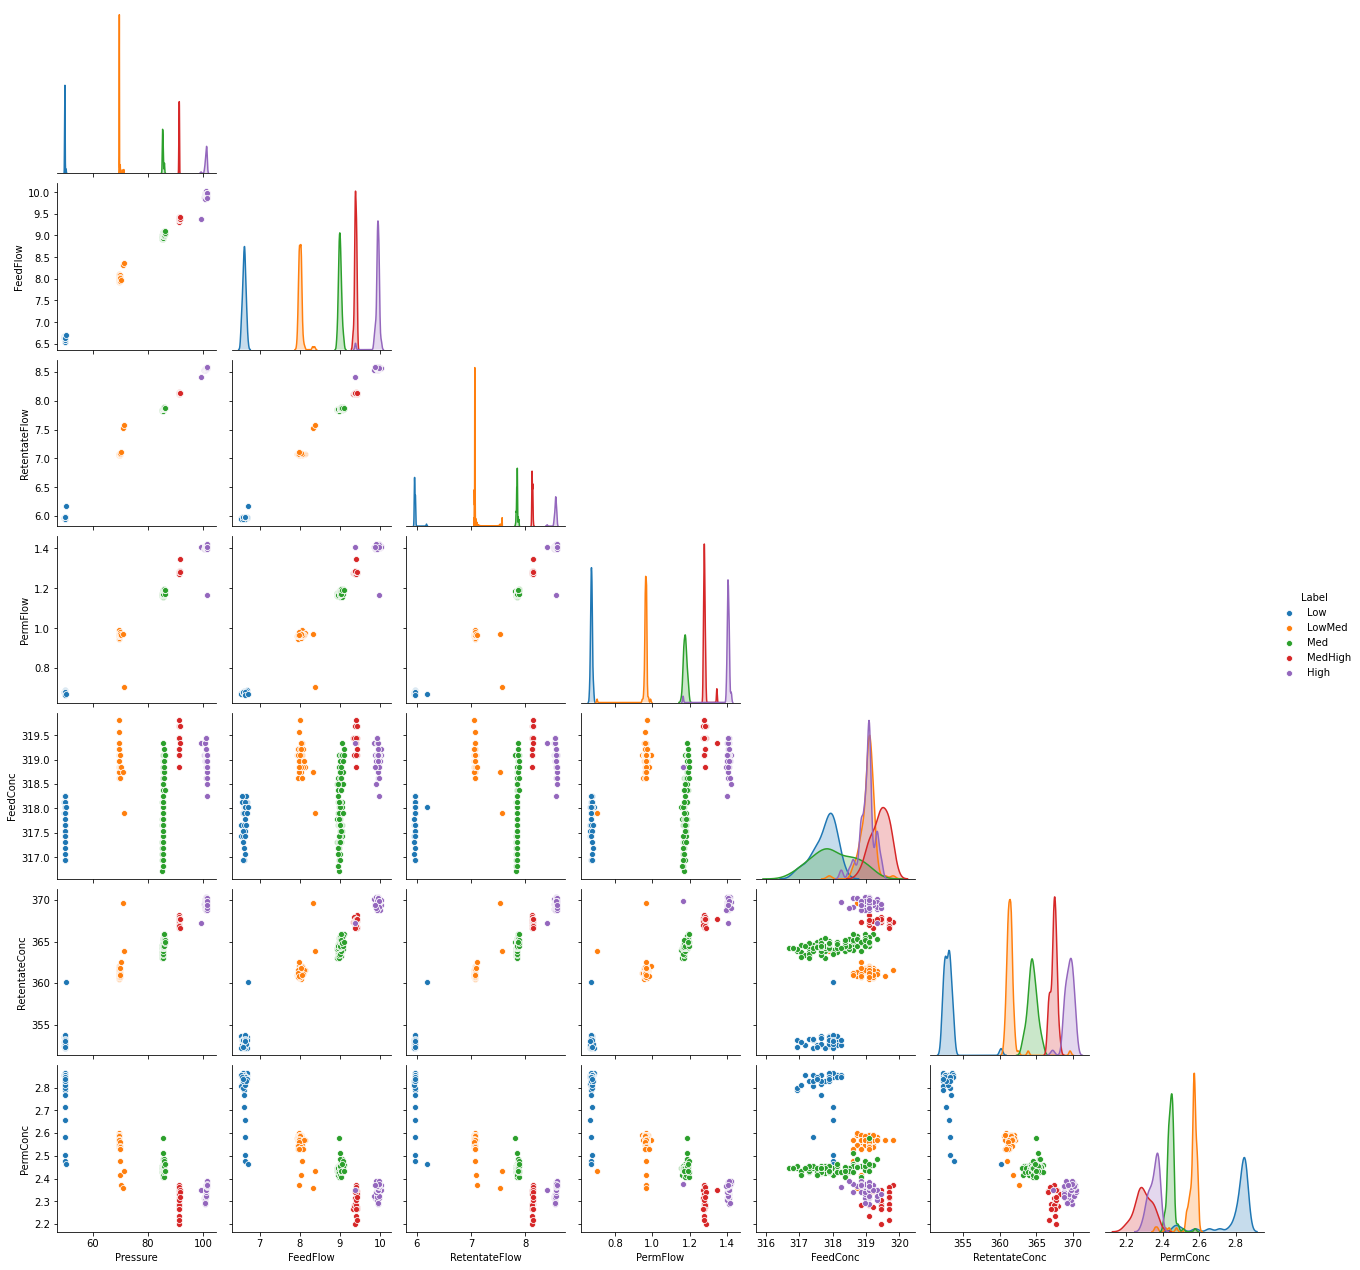

In [5]:
# We have some choices here, but I've been happiest with Seaborn plotting library
import seaborn as sns
g = sns.pairplot(df, corner='True', hue='Label')

From the pair plots above we can see a few things. Let's look more closely at the pair plots for five variables.

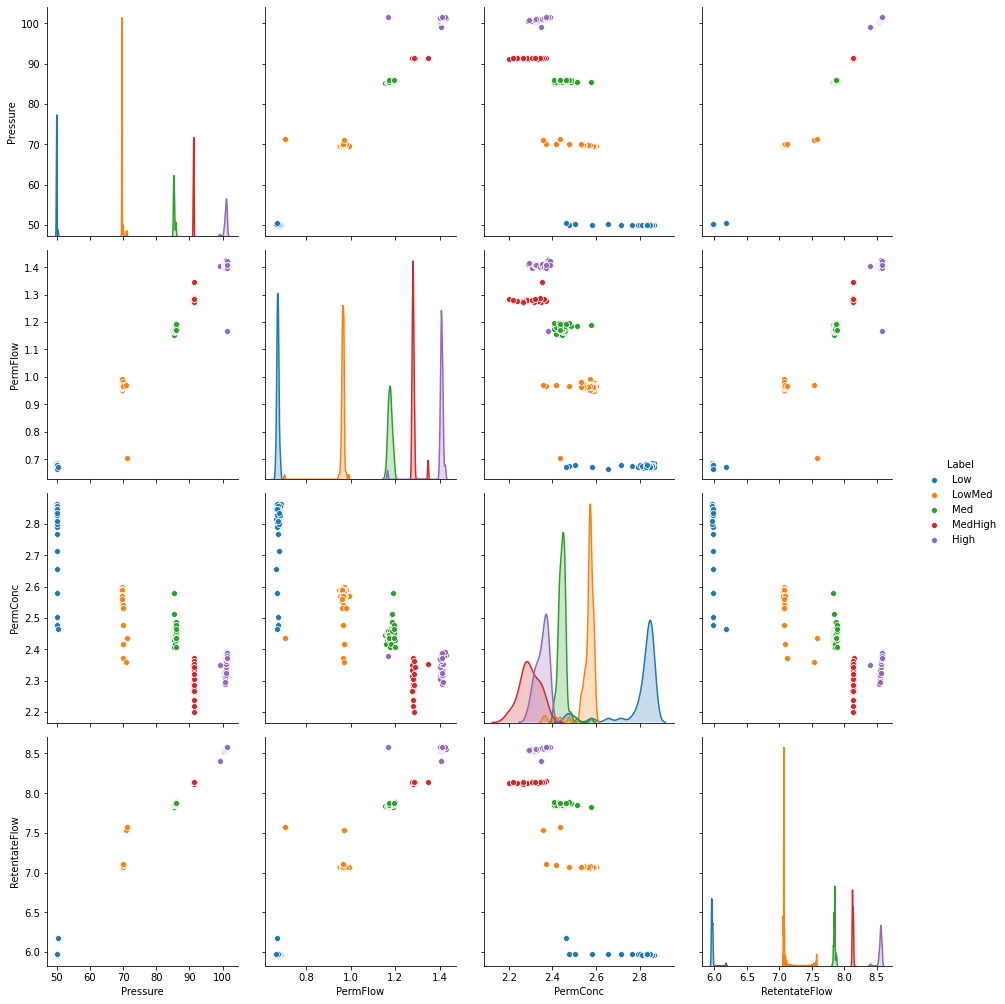

In [6]:
sns.set_context(font_scale=3.0)
g2 = sns.pairplot(df, vars=["Pressure", "PermFlow", "PermConc", "RetentateFlow"], hue='Label')
g2.fig.set_size_inches(14, 14)
#g2.savefig("pairplot.png")

At this point we're seeing some really strong correlations. We see some linear behavior with flow rates and concentrations vs. pressure. We also see clustering between permeate concentration and retentate concentration.

Now let's try some principal component analysis (PCA)

PCA works by projecting data onto new axes that best suit the data. Our first attempt will be to project the data onto three axes. Since this is an eigenvalue/eigenvector method, the axes are orthogonal to one another. Axis one will be the most significant factor, followed by two, three, etc.

We'll use the PCA function from scikit-learn

In [0]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler

Currently we are using a dataframe, but the next part requires the data to be in simple array form. Create a new object called data.

In [0]:
df_temp = df
df_temp = df_temp.drop(columns='Label')
data = df_temp.iloc[:,:].values

PCA requires that the data be normalized (mean = 0, variance = 1) Use the fit_transform function to do that

In [0]:
data_std = StandardScaler().fit_transform(data)

We'll project onto five axes at first

In [0]:
sklearn_pca = sklearnPCA(n_components=5)
data_PCA = sklearn_pca.fit_transform(data_std)

How successful were we? We can look at 

In [42]:
print(sklearn_pca.explained_variance_ratio_)

[0.84790784 0.12937746 0.01749716 0.00376157 0.00114375]


The first two axes account for a huge amount of the variance. 

In [43]:
twoAxesVariance = sklearn_pca.explained_variance_ratio_[0] + sklearn_pca.explained_variance_ratio_[1]
print(twoAxesVariance)

0.9772853005094455


Wow. **PCA was able to account for 97.7% of the variance by considering just two dimensions**. Our dataframe has 7 dimensions to it, but this says we can handle nearly everything by considering only two. We'll need to understand what those dimensions are, but first let's plot them.

In [44]:
#Plot it up and look at the results
import plotly.express as px
figPCA = px.scatter(x=data_PCA[:,0], y=data_PCA[:,1])
figPCA.update_xaxes(title_text='PC1')
figPCA.update_yaxes(title_text='PC2')
figPCA.show()

The x axis here is principal component axis 1 (PC1) and the data is spread out well from -4 to +5. PC2 does less, spreading the data out from -2 to +3.

In [45]:
figPCA2 = px.scatter(x=data_PCA[:,0], y=data_PCA[:,2])
figPCA2.update_xaxes(title_text='PC1')
figPCA2.update_yaxes(title_text='PC3')
figPCA2.show()

In [47]:
df_temp.head()

,Pressure,FeedFlow,RetentateFlow,PermFlow,FeedConc,RetentateConc,PermConc
0,49.822609,6.677412,5.959144,0.678688,318.142090,353.512390,2.857253
1,49.822609,6.641521,5.959144,0.681964,317.903900,352.440613,2.857253
2,49.827381,6.665091,5.959144,0.679234,318.142090,352.916992,2.857253
3,49.846458,6.619621,5.959144,0.669492,317.427612,352.202393,2.857253
4,49.870300,6.561592,5.959144,0.671403,318.142090,352.559692,2.857253


In [48]:
print(sklearn_pca.components_[0])

[-0.40617663 -0.40744559 -0.40755588 -0.40551718 -0.14798466 -0.4061091
  0.38940801]


In [49]:
print(sklearn_pca.components_[1])

[ 0.11109876  0.09652498  0.10252809  0.07442905 -0.97968437 -0.04634595
 -0.01894461]
